In [1]:
import sys

sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np

In [3]:
start_date = '2021-01-01'
end_date = '2021-09-07'

In [4]:
tic_list = ['ETH-USD']

In [5]:
tech_indicators = ['cci_30',
 'rsi_30',
 'rsi_14',
 'rsi_6',
 'dx_30', 
 'dx_14']


#tech_indicators = [
# 'open_2_sma', 
# 'rsi_6', 
# 'close_2_tema']

In [6]:
cwd = './CryptoModel/model.pkl'
reward_on_value = True
lookback_n = 7
config_max_step = 30
if reward_on_value:
    reward_scaling = 2 ** -10
else:
    reward_scaling = 2 ** -5

In [7]:
from neo_finrl.data_processors.processor_yahoofinance import YahooFinanceProcessor

In [8]:
data_downloader = YahooFinanceProcessor()

### Extract historical px

In [ ]:
stock_history_df = data_downloader.download_data(start_date, end_date, tic_list, '1D')

In [ ]:
data_downloader.time_interval = '1D'
stock_history_df = data_downloader.clean_data(stock_history_df)

In [ ]:
stock_history_df = data_downloader.add_technical_indicator(stock_history_df, tech_indicators)

In [ ]:
stock_history_df.to_csv('./ETH_hist.csv', index = False)

### Env module

In [9]:
from test_env.single_crypto_env import CryptoTradingEnv

### Setup env

In [10]:
stock_history_df = pd.read_csv('./ETH_hist.csv')
# to prevent policy_vl = nan
stock_history_df.fillna(1e-10, inplace = True)

In [11]:
price_array = stock_history_df[['open', 'adjcp', 'low', 'high']].values
tech_array = stock_history_df[tech_indicators].values

In [12]:
train_test_split_index = int(stock_history_df.shape[0] * 0.8)

In [13]:
print (f'{train_test_split_index} records for training')
print (f'{stock_history_df.shape[0] - train_test_split_index} records for testing')

200 records for training
50 records for testing


In [14]:
config = dict()

config['price_array'] = price_array[:train_test_split_index]
config['tech_array'] = tech_array[:train_test_split_index]
# randomly inital states for training
config['if_sequence'] = False
config['if_randomV'] = True
config['if_value'] = reward_on_value
config['lookback_n'] = lookback_n

initial_capital = 1e-5
initial_stocks = np.array([40.0])
max_step = config_max_step

In [15]:
crypto_env = CryptoTradingEnv(config, 
                              initial_capital=initial_capital,
                              initial_stocks=initial_stocks,
                              max_step = max_step, 
                              reward_scaling = reward_scaling
                              )

### Train RL

In [16]:
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan, VecNormalize
from stable_baselines3.common.logger import configure

In [17]:
tmp_path = "./tmp/sb3_log/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv"])

Logging to ./tmp/sb3_log/


In [19]:
env_train = DummyVecEnv([lambda : crypto_env])
env_train = VecCheckNan(env_train, raise_exception=True)
#env_train = VecNormalize(env_train)

model_name = 'ddpg'

if model_name == 'ppo':
    model = PPO("MlpPolicy", env_train, learning_rate=0.00025, 
                            n_steps=1024, batch_size=128, ent_coef=0.0, 
                            gamma=0.99, seed=312, verbose = 1)
elif model_name == 'ddpg':
    model = DDPG("MlpPolicy", env_train, learning_rate=0.00025, 
                 batch_size=128, gamma = 0.99, seed=312)
    
model.set_logger(new_logger)

In [20]:
model.learn(total_timesteps=1e5, tb_log_name = 'ppo', log_interval=10)
print('Training finished!')

---------------------------------
| time/              |          |
|    episodes        | 10       |
|    fps             | 256      |
|    time_elapsed    | 1        |
|    total timesteps | 300      |
| train/             |          |
|    actor_loss      | 0.539    |
|    critic_loss     | 19.3     |
|    learning_rate   | 0.00025  |
|    n_updates       | 180      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 20       |
|    fps             | 202      |
|    time_elapsed    | 2        |
|    total timesteps | 600      |
| train/             |          |
|    actor_loss      | 0.931    |
|    critic_loss     | 9.14     |
|    learning_rate   | 0.00025  |
|    n_updates       | 480      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 30       |
|    fps             | 189      |
|    time_elapsed    | 4        |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 220      |
|    fps             | 158      |
|    time_elapsed    | 41       |
|    total timesteps | 6600     |
| train/             |          |
|    actor_loss      | -9.33    |
|    critic_loss     | 39.9     |
|    learning_rate   | 0.00025  |
|    n_updates       | 6480     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 230      |
|    fps             | 158      |
|    time_elapsed    | 43       |
|    total timesteps | 6900     |
| train/             |          |
|    actor_loss      | -9.31    |
|    critic_loss     | 38.3     |
|    learning_rate   | 0.00025  |
|    n_updates       | 6780     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 240      |
|    fps             | 157      |
|    time_elapsed    | 45       |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 430      |
|    fps             | 156      |
|    time_elapsed    | 82       |
|    total timesteps | 12900    |
| train/             |          |
|    actor_loss      | -16.8    |
|    critic_loss     | 31.9     |
|    learning_rate   | 0.00025  |
|    n_updates       | 12780    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 440      |
|    fps             | 156      |
|    time_elapsed    | 84       |
|    total timesteps | 13200    |
| train/             |          |
|    actor_loss      | -17.2    |
|    critic_loss     | 33.2     |
|    learning_rate   | 0.00025  |
|    n_updates       | 13080    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 450      |
|    fps             | 156      |
|    time_elapsed    | 86       |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 640      |
|    fps             | 154      |
|    time_elapsed    | 123      |
|    total timesteps | 19200    |
| train/             |          |
|    actor_loss      | -22.4    |
|    critic_loss     | 38.1     |
|    learning_rate   | 0.00025  |
|    n_updates       | 19080    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 650      |
|    fps             | 154      |
|    time_elapsed    | 125      |
|    total timesteps | 19500    |
| train/             |          |
|    actor_loss      | -22.1    |
|    critic_loss     | 31.1     |
|    learning_rate   | 0.00025  |
|    n_updates       | 19380    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 660      |
|    fps             | 154      |
|    time_elapsed    | 128      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 850      |
|    fps             | 154      |
|    time_elapsed    | 165      |
|    total timesteps | 25500    |
| train/             |          |
|    actor_loss      | -25.3    |
|    critic_loss     | 30.7     |
|    learning_rate   | 0.00025  |
|    n_updates       | 25380    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 860      |
|    fps             | 154      |
|    time_elapsed    | 167      |
|    total timesteps | 25800    |
| train/             |          |
|    actor_loss      | -25.3    |
|    critic_loss     | 29.1     |
|    learning_rate   | 0.00025  |
|    n_updates       | 25680    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 870      |
|    fps             | 154      |
|    time_elapsed    | 169      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 1060     |
|    fps             | 154      |
|    time_elapsed    | 205      |
|    total timesteps | 31800    |
| train/             |          |
|    actor_loss      | -27.4    |
|    critic_loss     | 29.5     |
|    learning_rate   | 0.00025  |
|    n_updates       | 31680    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1070     |
|    fps             | 154      |
|    time_elapsed    | 208      |
|    total timesteps | 32100    |
| train/             |          |
|    actor_loss      | -26.7    |
|    critic_loss     | 32.9     |
|    learning_rate   | 0.00025  |
|    n_updates       | 31980    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1080     |
|    fps             | 154      |
|    time_elapsed    | 210      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 1270     |
|    fps             | 151      |
|    time_elapsed    | 252      |
|    total timesteps | 38100    |
| train/             |          |
|    actor_loss      | -29.5    |
|    critic_loss     | 26.6     |
|    learning_rate   | 0.00025  |
|    n_updates       | 37980    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1280     |
|    fps             | 151      |
|    time_elapsed    | 253      |
|    total timesteps | 38400    |
| train/             |          |
|    actor_loss      | -29.5    |
|    critic_loss     | 26.3     |
|    learning_rate   | 0.00025  |
|    n_updates       | 38280    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1290     |
|    fps             | 151      |
|    time_elapsed    | 255      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 1480     |
|    fps             | 150      |
|    time_elapsed    | 294      |
|    total timesteps | 44400    |
| train/             |          |
|    actor_loss      | -32.4    |
|    critic_loss     | 26.8     |
|    learning_rate   | 0.00025  |
|    n_updates       | 44280    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1490     |
|    fps             | 150      |
|    time_elapsed    | 296      |
|    total timesteps | 44700    |
| train/             |          |
|    actor_loss      | -33.5    |
|    critic_loss     | 27.5     |
|    learning_rate   | 0.00025  |
|    n_updates       | 44580    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1500     |
|    fps             | 150      |
|    time_elapsed    | 298      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 1690     |
|    fps             | 151      |
|    time_elapsed    | 335      |
|    total timesteps | 50700    |
| train/             |          |
|    actor_loss      | -35.3    |
|    critic_loss     | 28.9     |
|    learning_rate   | 0.00025  |
|    n_updates       | 50580    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1700     |
|    fps             | 150      |
|    time_elapsed    | 337      |
|    total timesteps | 51000    |
| train/             |          |
|    actor_loss      | -35.5    |
|    critic_loss     | 32.3     |
|    learning_rate   | 0.00025  |
|    n_updates       | 50880    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1710     |
|    fps             | 150      |
|    time_elapsed    | 339      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 1900     |
|    fps             | 150      |
|    time_elapsed    | 377      |
|    total timesteps | 57000    |
| train/             |          |
|    actor_loss      | -37.2    |
|    critic_loss     | 33.7     |
|    learning_rate   | 0.00025  |
|    n_updates       | 56880    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1910     |
|    fps             | 150      |
|    time_elapsed    | 379      |
|    total timesteps | 57300    |
| train/             |          |
|    actor_loss      | -37.5    |
|    critic_loss     | 29.2     |
|    learning_rate   | 0.00025  |
|    n_updates       | 57180    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1920     |
|    fps             | 150      |
|    time_elapsed    | 381      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 2110     |
|    fps             | 151      |
|    time_elapsed    | 419      |
|    total timesteps | 63300    |
| train/             |          |
|    actor_loss      | -38.8    |
|    critic_loss     | 35.6     |
|    learning_rate   | 0.00025  |
|    n_updates       | 63180    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2120     |
|    fps             | 151      |
|    time_elapsed    | 421      |
|    total timesteps | 63600    |
| train/             |          |
|    actor_loss      | -37.8    |
|    critic_loss     | 34.3     |
|    learning_rate   | 0.00025  |
|    n_updates       | 63480    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2130     |
|    fps             | 151      |
|    time_elapsed    | 423      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 2320     |
|    fps             | 150      |
|    time_elapsed    | 462      |
|    total timesteps | 69600    |
| train/             |          |
|    actor_loss      | -39.5    |
|    critic_loss     | 38       |
|    learning_rate   | 0.00025  |
|    n_updates       | 69480    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2330     |
|    fps             | 150      |
|    time_elapsed    | 464      |
|    total timesteps | 69900    |
| train/             |          |
|    actor_loss      | -39.6    |
|    critic_loss     | 39       |
|    learning_rate   | 0.00025  |
|    n_updates       | 69780    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2340     |
|    fps             | 150      |
|    time_elapsed    | 466      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 2530     |
|    fps             | 150      |
|    time_elapsed    | 503      |
|    total timesteps | 75900    |
| train/             |          |
|    actor_loss      | -39.8    |
|    critic_loss     | 40.5     |
|    learning_rate   | 0.00025  |
|    n_updates       | 75780    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2540     |
|    fps             | 150      |
|    time_elapsed    | 506      |
|    total timesteps | 76200    |
| train/             |          |
|    actor_loss      | -40.2    |
|    critic_loss     | 36.8     |
|    learning_rate   | 0.00025  |
|    n_updates       | 76080    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2550     |
|    fps             | 150      |
|    time_elapsed    | 508      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 2740     |
|    fps             | 151      |
|    time_elapsed    | 542      |
|    total timesteps | 82200    |
| train/             |          |
|    actor_loss      | -40.6    |
|    critic_loss     | 35.3     |
|    learning_rate   | 0.00025  |
|    n_updates       | 82080    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2750     |
|    fps             | 151      |
|    time_elapsed    | 544      |
|    total timesteps | 82500    |
| train/             |          |
|    actor_loss      | -41.3    |
|    critic_loss     | 40.2     |
|    learning_rate   | 0.00025  |
|    n_updates       | 82380    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2760     |
|    fps             | 151      |
|    time_elapsed    | 546      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 2950     |
|    fps             | 152      |
|    time_elapsed    | 580      |
|    total timesteps | 88500    |
| train/             |          |
|    actor_loss      | -42.2    |
|    critic_loss     | 43.6     |
|    learning_rate   | 0.00025  |
|    n_updates       | 88380    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2960     |
|    fps             | 152      |
|    time_elapsed    | 582      |
|    total timesteps | 88800    |
| train/             |          |
|    actor_loss      | -42      |
|    critic_loss     | 33.9     |
|    learning_rate   | 0.00025  |
|    n_updates       | 88680    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2970     |
|    fps             | 152      |
|    time_elapsed    | 584      |
|    total tim

---------------------------------
| time/              |          |
|    episodes        | 3160     |
|    fps             | 153      |
|    time_elapsed    | 618      |
|    total timesteps | 94800    |
| train/             |          |
|    actor_loss      | -42.3    |
|    critic_loss     | 32.1     |
|    learning_rate   | 0.00025  |
|    n_updates       | 94680    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3170     |
|    fps             | 153      |
|    time_elapsed    | 620      |
|    total timesteps | 95100    |
| train/             |          |
|    actor_loss      | -42.1    |
|    critic_loss     | 41.6     |
|    learning_rate   | 0.00025  |
|    n_updates       | 94980    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3180     |
|    fps             | 153      |
|    time_elapsed    | 622      |
|    total tim

In [21]:
model.save(cwd)
print('Trained model saved in ' + str(cwd))

Trained model saved in ./CryptoModel/model.pkl


### Test RL

In [22]:
#test on the testing env
def testRun(model, env_instance, run_n = 1):
    exp_return = []
    for i in range(run_n):
        state = env_instance.reset()
        episode_returns = []  # the cumulative_return / initial_account
        
        done = False
        # append initial asset
        episode_returns.append(env_instance.total_asset)
        
        while not done:
            action = model.predict(state)[0]
            #print (action)
            state, reward, done, _ = env_instance.step(action)

            #print (env_instance.stocks)
            #total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day + env_instance.run_index, 1] \
            #                                     * env_instance.stocks).sum()
            #episode_return = total_asset / env_instance.initial_total_asset

            episode_returns.append(env_instance.total_asset)

        #print('Test Finished!')
        exp_return.append(episode_returns)
    return exp_return

In [23]:
test_config = dict()

start_idx = train_test_split_index
start_idx = 100
test_config['price_array'] = price_array[start_idx:]
test_config['tech_array'] = tech_array[start_idx:]

#randomly start day index for back testing
test_config['if_sequence'] = False
# disable random initial capital 
test_config['if_randomV'] = False

test_config['if_value'] = reward_on_value
test_config['lookback_n'] = lookback_n

max_step = min(test_config['price_array'].shape[0]-1, 50)
#max_step = test_config['price_array'].shape[0] - 1

In [24]:
#test_env = CryptoTradingEnv(test_config, \
#                            initial_capital=1e4, \
#                            initial_stocks = np.array([0.00001]), \
#                            max_step = max_step)

test_env = CryptoTradingEnv(test_config, \
                            initial_capital=0, \
                            max_step = max_step, \
                           initial_stocks = np.array([20.0]), 
                           reward_scaling = reward_scaling)

#test_model = PPO.load(cwd)
test_model = DDPG.load(cwd)
#test_model = model
test_model = test_model.policy.eval()

In [25]:
cumulative_return = testRun(test_model, test_env, run_n = 50)

if test_config['if_value']:
    holding_return = price_array[start_idx + max_step, 1] / price_array[start_idx, 1]
else:
    holding_return = 1.0

print ("Holding-strategy return: ", holding_return)

Holding-strategy return:  1.119087159078271


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

Mean: 1.4411203542787745; Min: 0.9973957209904446; Max 2.0985000767976154


(array([4., 7., 9., 6., 8., 3., 4., 4., 3., 2.]),
 array([0.99739572, 1.10750616, 1.21761659, 1.32772703, 1.43783746,
        1.5479479 , 1.65805833, 1.76816877, 1.87827921, 1.98838964,
        2.09850008]),
 <a list of 10 Patch objects>)

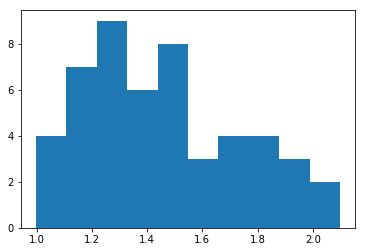

In [27]:
c_ret = np.array(cumulative_return)
c_ret_vec = (c_ret[:, -1]/c_ret[:, 0])

print (f'Mean: {np.mean(c_ret_vec)}; Min: {min(c_ret_vec)}; Max {max(c_ret_vec)}')
plt.hist(c_ret_vec)

#### Test run a sequence

In [74]:
test_config = dict()

start_idx = 150
test_config['price_array'] = price_array[start_idx:]
test_config['tech_array'] = tech_array[start_idx:]

#randomly start day index for back testing
test_config['if_sequence'] = True
# disable random initial capital 
test_config['if_randomV'] = False

test_config['if_value'] = reward_on_value
test_config['lookback_n'] = lookback_n

max_step = min(test_config['price_array'].shape[0]-1, 100)

In [75]:
test_env = CryptoTradingEnv(test_config, \
                            initial_capital=0, \
                            max_step = max_step, \
                           initial_stocks = np.array([20.0]), 
                           reward_scaling = reward_scaling)

#test_model = PPO.load(cwd)
test_model = DDPG.load(cwd)

test_model = test_model.policy.eval()

In [76]:
cumulative_return = testRun(test_model, test_env, run_n = 1)

if test_config['if_value']:
    holding_return = price_array[start_idx + max_step, 1] / price_array[start_idx, 1]
else:
    holding_return = 1.0

print ("Holding-strategy return: ", holding_return)

initial stock: [20.] inital amount:  0
initial asset:  47806.109375
[Day 1] BUY: 0.0
[Day 2] BUY: 0.0
[Day 3] SELL: 20.0
[Day 4] BUY: 19.8127
[Day 5] SELL: 19.8127
[Day 6] SELL: 0.0
[Day 7] SELL: 0.0
[Day 8] SELL: 0.0
[Day 10] SELL: 0.0
[Day 11] SELL: 0.0
[Day 13] SELL: 0.0
[Day 14] SELL: 0.0
[Day 16] SELL: 0.0
[Day 18] SELL: 0.0
[Day 19] SELL: 0.0
[Day 21] SELL: 0.0
[Day 22] SELL: 0.0
[Day 24] BUY: 29.4566
[Day 25] SELL: 2.9607
[Day 26] SELL: 26.495900000000002
[Day 28] BUY: 31.831000000000003
[Day 31] SELL: 31.831000000000003
[Day 32] SELL: 0.0
[Day 34] SELL: 0.0
[Day 36] SELL: 0.0
[Day 37] BUY: 19.923000000000002
[Day 39] BUY: 6.5543000000000005
[Day 41] SELL: 26.4773
[Day 42] BUY: 4.8041
[Day 43] SELL: 4.7996
[Day 45] SELL: 0.0044
[Day 46] SELL: 0.0
[Day 47] SELL: 0.0
[Day 48] SELL: 0.0
[Day 49] SELL: 0.0
[Day 50] SELL: 0.0
[Day 52] SELL: 0.0001
[Day 54] SELL: 0.0
[Day 56] SELL: 0.0
[Day 57] SELL: 0.0
[Day 58] SELL: 0.0
[Day 59] SELL: 0.0
[Day 60] SELL: 0.0
[Day 61] SELL: 0.0
[Day 

Text(0.5, 0, 'time')

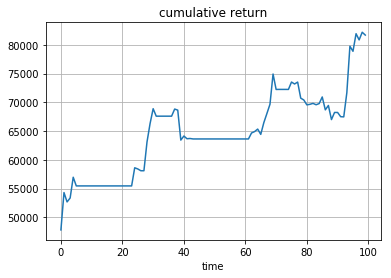

In [77]:
plt.plot(cumulative_return[0], label='agent return')
plt.grid()
plt.title('cumulative return')
plt.xlabel('time')

Text(0.5, 0, 'time')

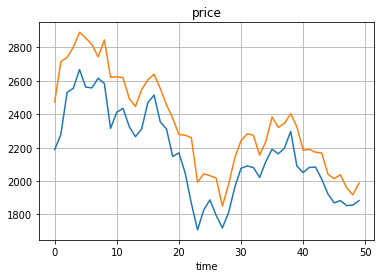

In [78]:
plt.plot(test_config['price_array'][:50, 2:4], label='px')
plt.grid()
plt.title('price')
plt.xlabel('time')